# Comparing Classifiers and their performance

Dataset source: UCI Machine Learning repository - Portugese banking institute's marketing campaign



In [671]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, time
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint
from sklearn.metrics import f1_score,accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## Load the dataset

In [672]:
dataset = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [673]:
dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [674]:
## Using bank information features (columns 1 - 7) to create the model
df = pd.concat([dataset.iloc[:,:7],dataset.iloc[:,-1:]],axis=1)

# Inspect the data

In [675]:
## Print data shape, info
print("Dataset shape: ")
print(df.shape)
print("\nDataset info:")
df.info()

Dataset shape: 
(41188, 8)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        41188 non-null  int64 
 1   job        41188 non-null  object
 2   marital    41188 non-null  object
 3   education  41188 non-null  object
 4   default    41188 non-null  object
 5   housing    41188 non-null  object
 6   loan       41188 non-null  object
 7   y          41188 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.5+ MB


In [676]:
## Check for null feature
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
housing      0
loan         0
y            0
dtype: int64


Subscribed deposit Count :
yes     4640
no     36548
Name: y, dtype: int64

Subscribed deposit Percent
no     88.734583
yes    11.265417
Name: y, dtype: float64


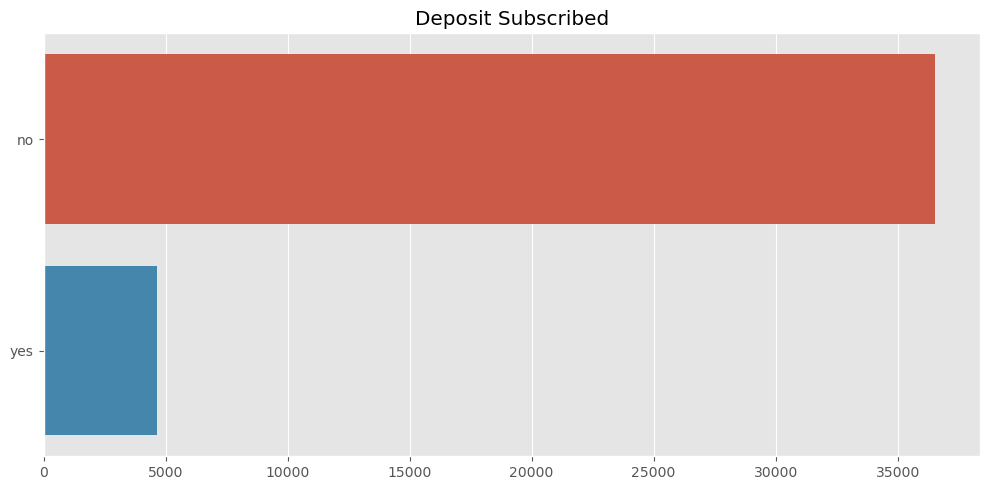

In [677]:
## Display deposit signup count
print("\nSubscribed deposit Count :")
item_counts = df["y"].value_counts().sort_values()
print(item_counts)

## signup percent
print("\nSubscribed deposit Percent" )
class_values = (df['y'].value_counts()/df['y'].value_counts().sum())*100
print(class_values)

## Visualize the signup
plt.figure(figsize=(10,5))    
sns.barplot(x=df["y"].value_counts().values, y=df["y"].value_counts().index, data=df)    
plt.title("Deposit Subscribed")    
plt.tight_layout()

Text(0.5, 1.0, 'Customer Age')

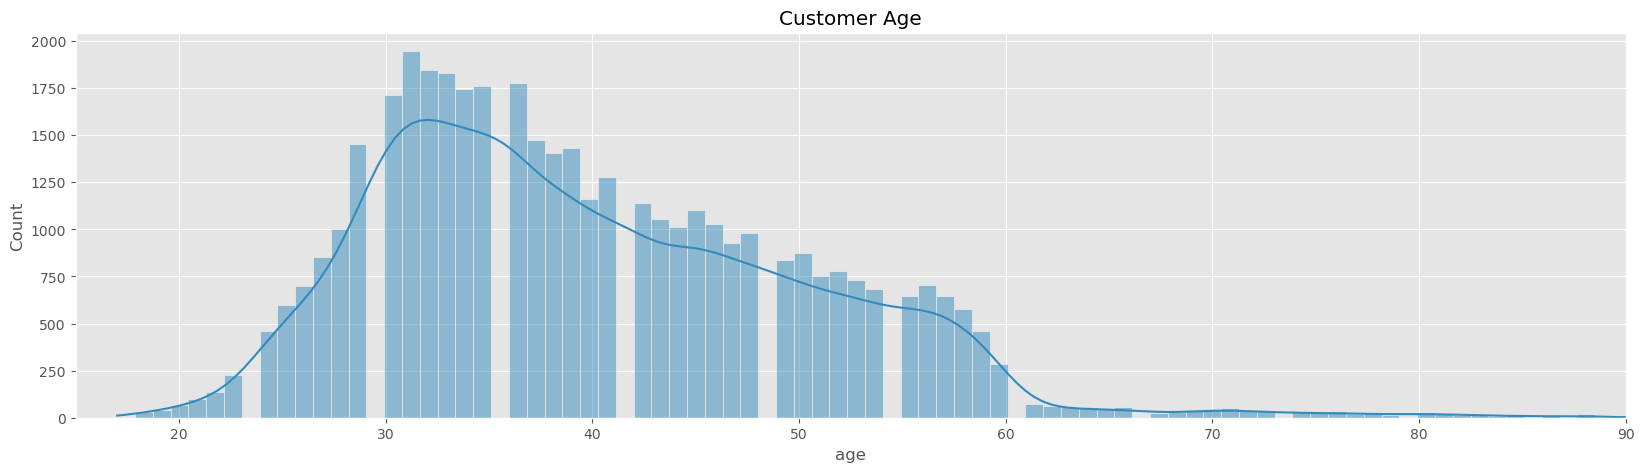

In [678]:
## Univariate analysis - Age - identify insights
plt.figure(figsize=(20,5))
sns.histplot(df['age'],kde=True)
plt.xlim(15, 90)
plt.title('Customer Age')

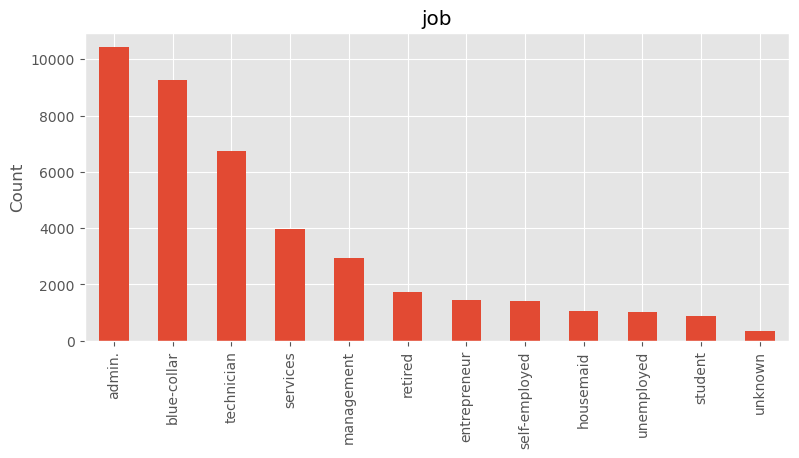

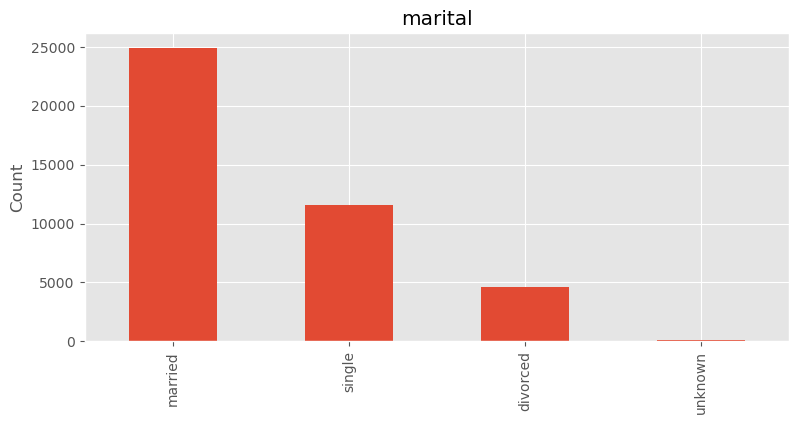

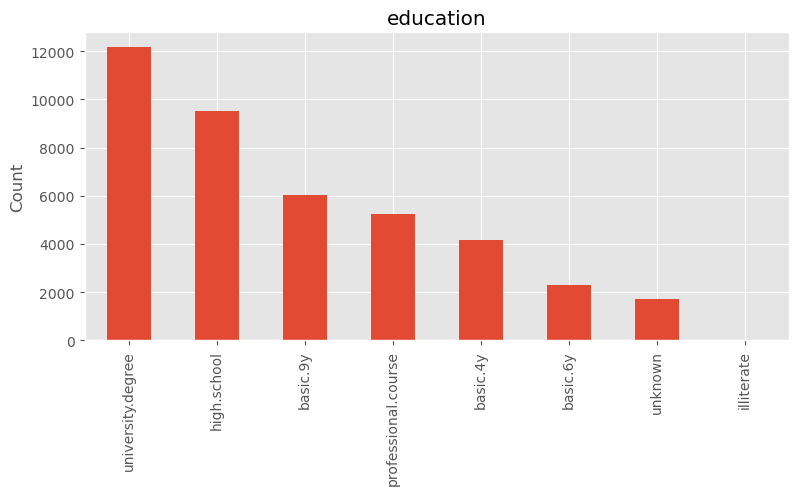

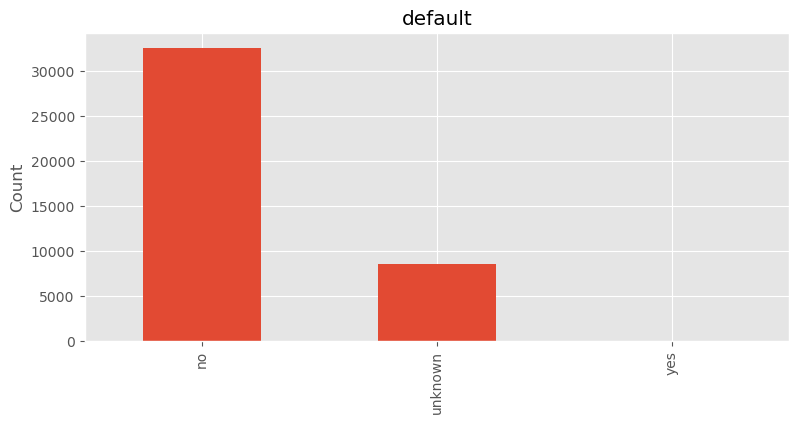

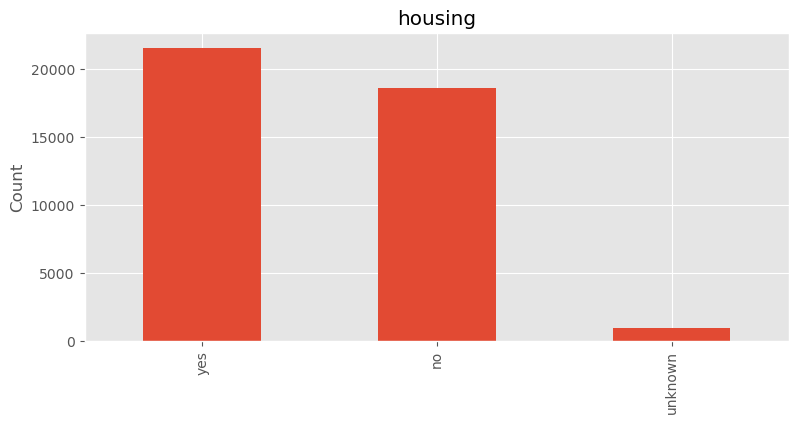

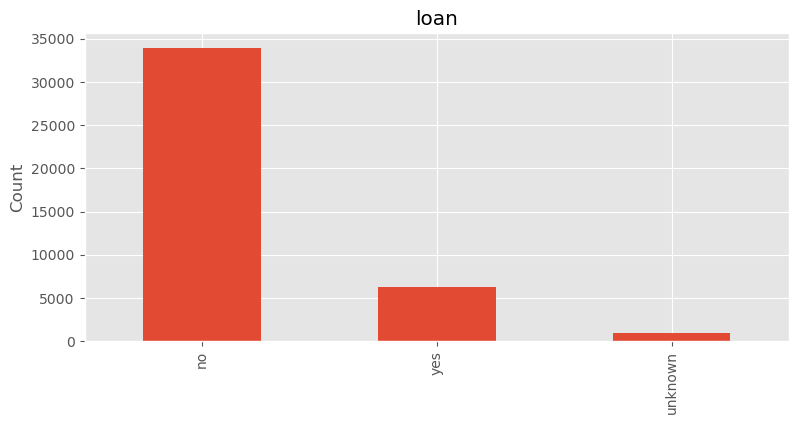

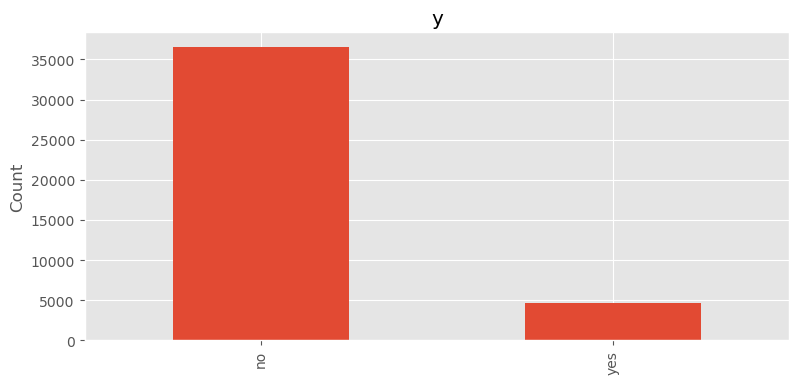

In [679]:
## Visualize all object features 
categorical_col = df.select_dtypes(include=['object']).columns
plt.style.use('ggplot')
for column in categorical_col:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    plt.ylabel('Count')
    df[column].value_counts().plot(kind='bar')
    plt.title(column)

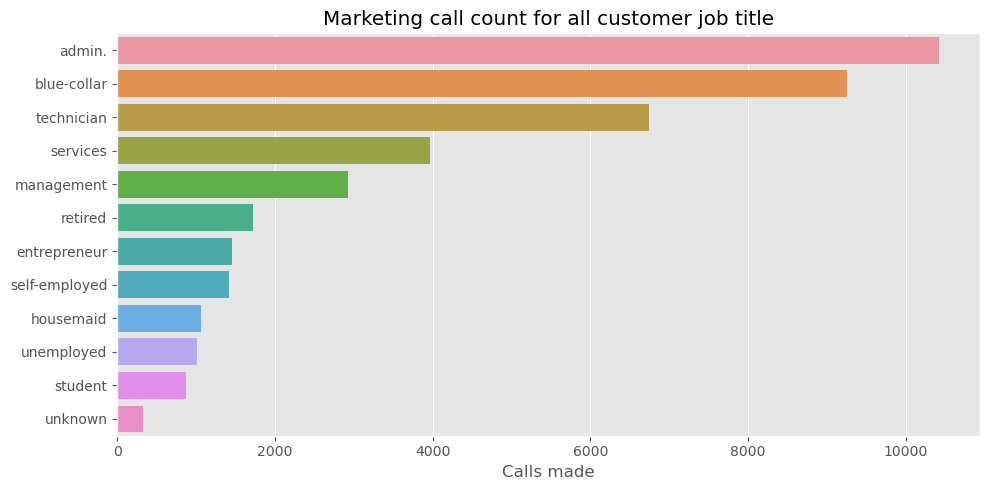

In [680]:
## Visualize phone call count for every customer job title
plt.figure(figsize=(10,5))    
sns.barplot(x=df["job"].value_counts().values, y=df["job"].value_counts().index, data=df)    
plt.title("Marketing call count for all customer job title")   
plt.xlabel('Calls made')
plt.tight_layout()

Text(0.5, 1.0, 'Customer job title with signup success')

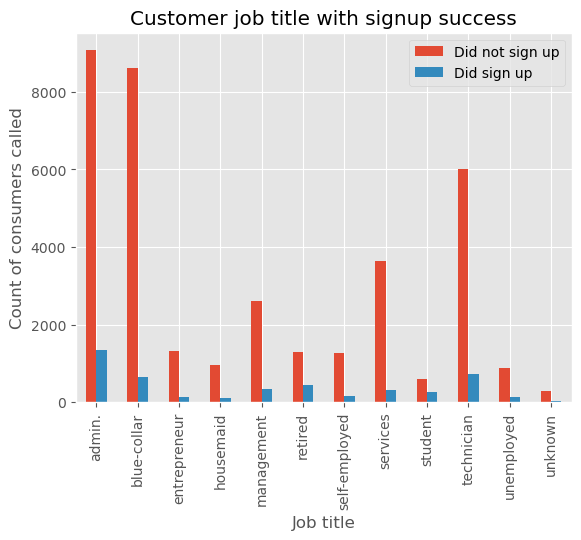

In [681]:
## Visualize phone call count for every customer job title
table = pd.crosstab(df.job, df.y)
table.columns = ['Did not sign up', 'Did sign up']
table.plot(kind='bar')
plt.xlabel('Job title')
plt.ylabel('Count of consumers called')
plt.grid(True)
plt.title('Customer job title with signup success')

# Perform data cleanup

In [682]:
## Data cleanup
## dropping the martial status which is unknown from our dataframe
df.drop(df[df.age < 25].index, inplace=True)
df.drop(df[df.age > 60].index, inplace=True)
df.drop(df[df['marital'] == "unknown"].index, inplace=True)
df.drop(df[df['loan'] == "unknown"].index, inplace=True)
df.drop(df[df['housing'] == "unknown"].index, inplace=True)

Text(0.5, 1.0, 'Customer Age')

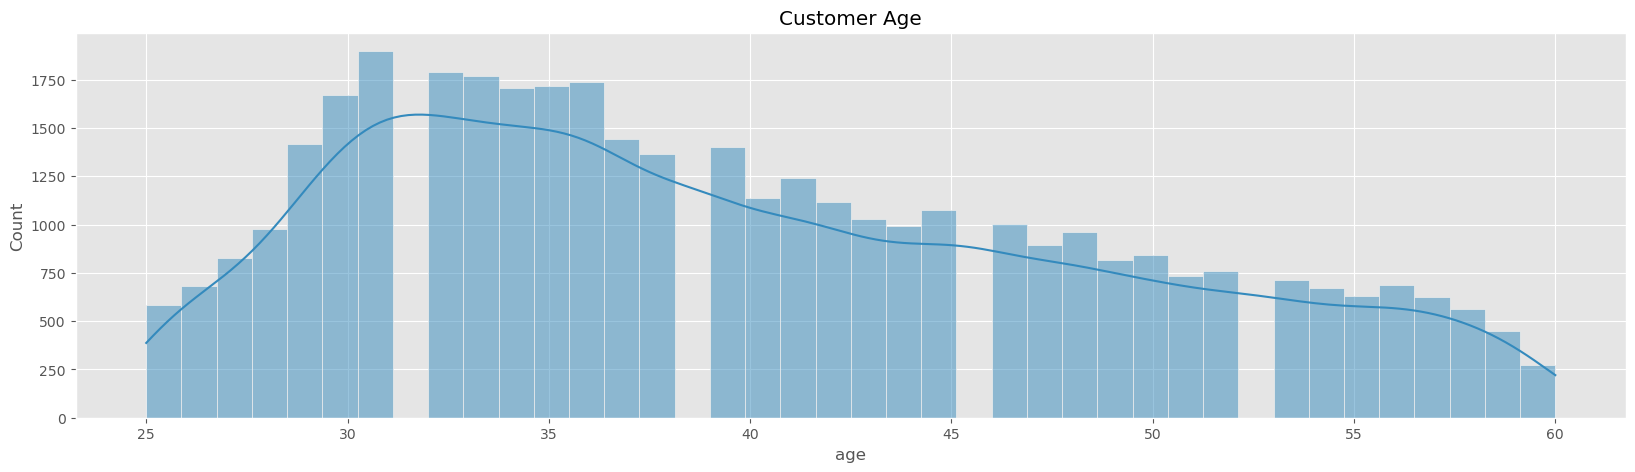

In [683]:
## Visualize the Customer's age in the modified dataset
plt.figure(figsize=(20,5))
sns.histplot(df['age'],kde=True)
plt.title('Customer Age')

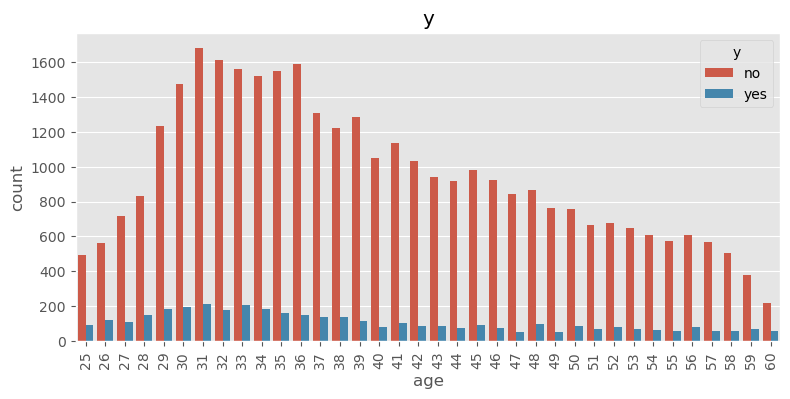

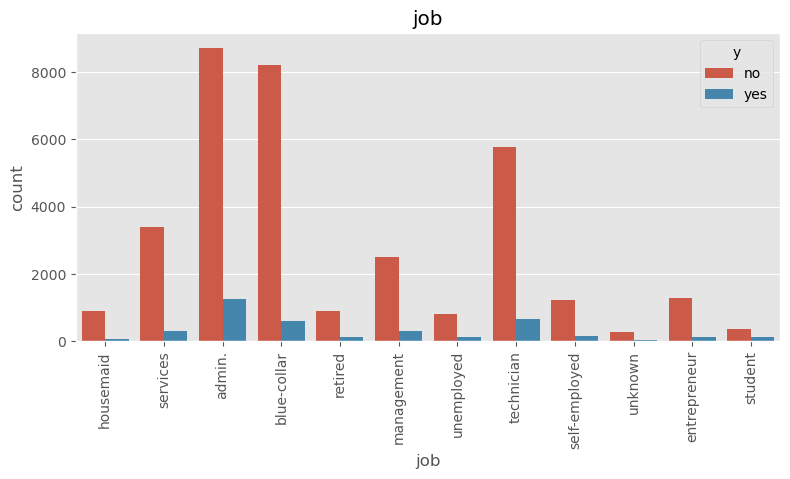

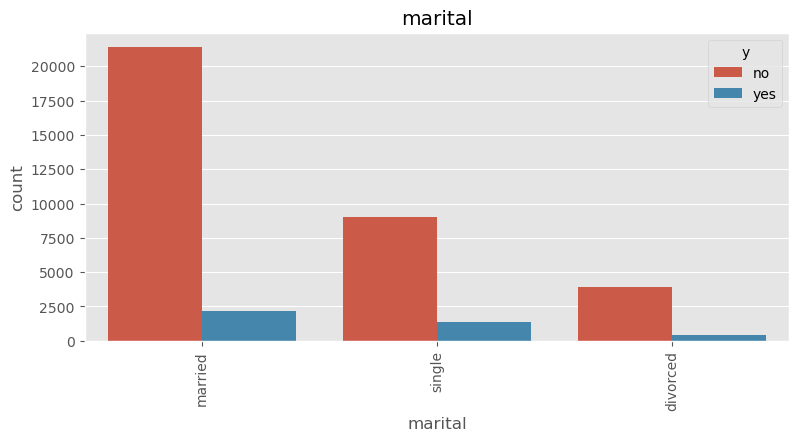

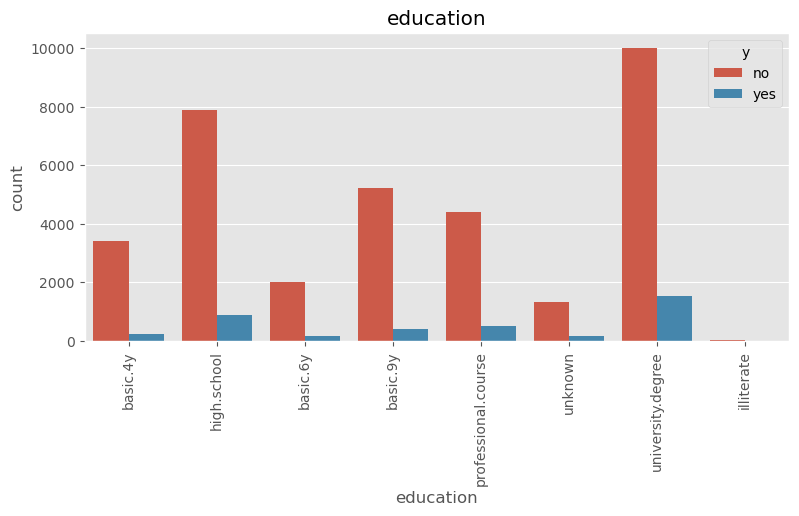

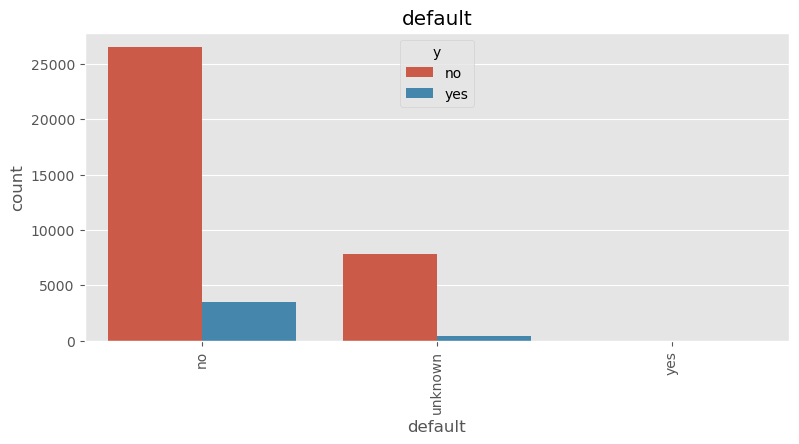

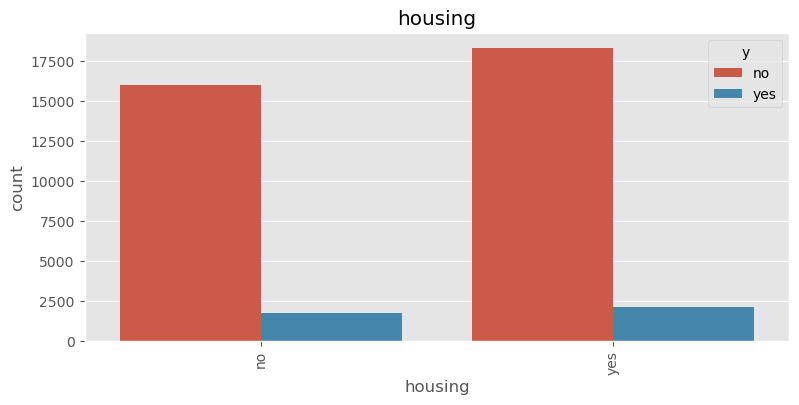

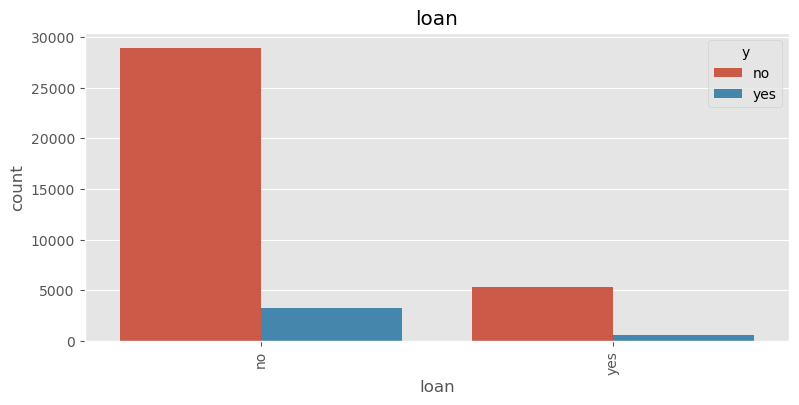

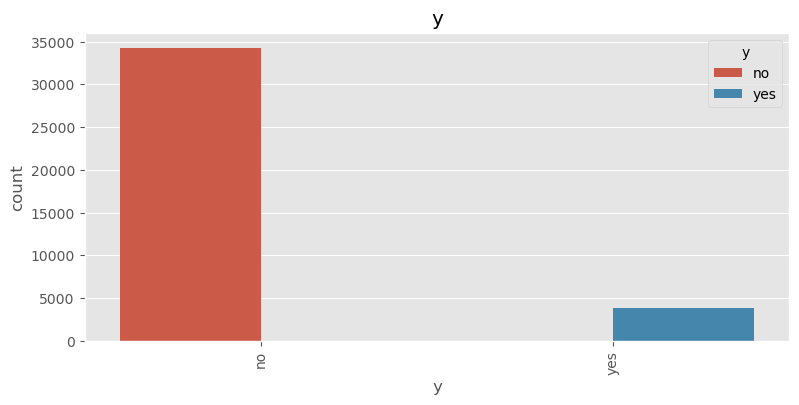

In [684]:
## Bivariate analysis between a feature and the output
plt.figure(figsize=(20,4))
plt.subplot(121)
sns.countplot(x=df['age'],hue=df['y'],data=df)
plt.title(column)    
plt.xticks(rotation=90)

for column in categorical_col:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.countplot(x=df[column],hue=df['y'],data=df)
    plt.title(column)    
    plt.xticks(rotation=90)

## Findings from the visuals above

1.  Majority of the customers called during marketing campaign are between 25 years to 60 years.
2.  Marital status of unknown found in 80 samples. They dont add value to our model and will drop from the sample set
3.  Majority of the customers do not have a credit in default
4.  The top three professions that our customers belong to are - administration, blue-collar jobs and technicians.
5.  2.4% of the samples do not have loan default status nor housing loan data. Dropping then as they might skew the model.
6.  More customers have housing loan but few have personal loan.
7.  Administrators, blue-collar and technician are the top 3 job types reached out during campaign
8.  Retiree have signed up more than any other category
9.  Customers between age 29 years to 38 years have signed up for term deposit 
10. Degree holders have signed up more
11. Target variable shows an imbalance ratio of 89:11

# Business Objective

The marketing dataset is of a Portuguese banking institute containing details about marketing campaign's phone calls made to its existing customers to setup term deposit with the institute. Analyzing the previous marketing programs, many customers are either declining to create a term deposit even when they are dont have financial obligations such as personal loan or mortgage. Our business objective is to help the banking institute in developing a best classifier model which can predict the success rate of a customer opening the term deposit. Using features like customer's age,job,marital status,education,previous loan default,housing loan and personal loan, the objective is to develop an effective classifer so that the financial institute's marketing team can target their marketing effort with better success rate by identifying customers who have a high chance of signing up for term deposit with the financial institute.

### Inspect the data and create feature set and target value

In [743]:
## Selecting the bank information features in the first 7 columns
X = df.iloc[:, : 7]
y = df['y']
## normalize the output
y = pd.Series(np.where(y == 'yes', 1, 0),y.index)

KeyError: 'y'

In [686]:
## check the feature set
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38198 entries, 0 to 41186
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        38198 non-null  int64 
 1   job        38198 non-null  object
 2   marital    38198 non-null  object
 3   education  38198 non-null  object
 4   default    38198 non-null  object
 5   housing    38198 non-null  object
 6   loan       38198 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.3+ MB


In [687]:
## Standardize categorical feature
## create dummy variables for categorical features
count = 0
column_types = X.dtypes
column_name  = X.columns
column_list=[]
for col in column_types:
    ## if column type is Object
    if col.name=="object":
        column_list.append(column_name[count])
    count+=1

## Create dummies for object columns
df=pd.get_dummies(X,columns=column_list)

In [688]:
## Check the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38198 entries, 0 to 41186
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   age                            38198 non-null  int64
 1   job_admin.                     38198 non-null  uint8
 2   job_blue-collar                38198 non-null  uint8
 3   job_entrepreneur               38198 non-null  uint8
 4   job_housemaid                  38198 non-null  uint8
 5   job_management                 38198 non-null  uint8
 6   job_retired                    38198 non-null  uint8
 7   job_self-employed              38198 non-null  uint8
 8   job_services                   38198 non-null  uint8
 9   job_student                    38198 non-null  uint8
 10  job_technician                 38198 non-null  uint8
 11  job_unemployed                 38198 non-null  uint8
 12  job_unknown                    38198 non-null  uint8
 13  marital_divorced

## Train/Test Split


In [689]:
## Split to train, test dataset
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.8, random_state=42)

### Create a new dataframe to save classifier performance

In [690]:
df_results = pd.DataFrame(columns=['Model','Train Time','Train Accuracy','Test Accuracy'])

### Create a baseline model - RandomForestClassifier

In [691]:
## Create a baseline model  - Using RandomForestClassifier
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100],
    'max_features': [3, 8],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [2, 5],
    'n_estimators': [300, 500]
}
forest = RandomForestClassifier(random_state=42, 
                                class_weight="balanced")
rnd_search = RandomizedSearchCV(forest, 
                                param_distributions = param_grid,
                                n_iter = 5, 
                                cv = 5, 
                                scoring ='f1_weighted', 
                                random_state = 42)
## fit the model
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=5,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [50, 100],
                                        'max_features': [3, 8],
                                        'min_samples_leaf': [3, 5],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [300, 500]},
                   random_state=42, scoring='f1_weighted')

In [692]:
## Best estimator parameters
cvres = rnd_search.cv_results_
for f1_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f1_score, params)

0.7939956970948625 {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 8, 'max_depth': 100, 'bootstrap': True}
0.7939956970948625 {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 8, 'max_depth': 50, 'bootstrap': True}
0.80906638727789 {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 8, 'max_depth': 100, 'bootstrap': True}
0.7960140081293937 {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 100, 'bootstrap': True}
0.80906638727789 {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 8, 'max_depth': 50, 'bootstrap': True}


In [693]:
## Use the best model to identify optimal parameters
best_model = rnd_search.best_estimator_

In [696]:
## Compute the CV score
scores = cross_val_score(best_model, X_train, y_train,scoring="f1_weighted", cv=5)
print("Train data CV Score :\n ",scores)

Train data CV Score :
  [0.8143566  0.80806953 0.80912221 0.81077402 0.80300958]


In [697]:
## Print the model accuracy and classification report on train data
ypred_train = best_model.predict(X_train)
print("Model accuracy using train data:",accuracy_score(y_train, ypred_train))

print("\nClassification report: train data")
print(classification_report(y_train, ypred_train))

Model accuracy using train data: 0.8582275166906663

Classification report: train data
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      6852
           1       0.40      0.76      0.53       787

    accuracy                           0.86      7639
   macro avg       0.69      0.82      0.72      7639
weighted avg       0.91      0.86      0.88      7639



In [698]:
## Print the model accuracy and classification report on test data
ypred_test = best_model.predict(X_test)
print("Model accuracy using test data:",accuracy_score(y_test, ypred_test))

print("\nClassification report: test data")
print(classification_report(y_test, ypred_test))

Model accuracy using test data: 0.7814064596354593

Classification report: test data
              precision    recall  f1-score   support

           0       0.91      0.84      0.87     27474
           1       0.15      0.25      0.19      3085

    accuracy                           0.78     30559
   macro avg       0.53      0.55      0.53     30559
weighted avg       0.83      0.78      0.80     30559



In [699]:
## Use the optimal parameters from best estimator to create the RandomForestclassifier and fit using train data
reg_tree_mod = RandomForestClassifier(random_state=42, 
                                      class_weight="balanced",
                                      n_estimators= 300, 
                                      min_samples_split= 5,
                                      min_samples_leaf= 3, 
                                      max_features= 8, 
                                      max_depth= 20, 
                                      bootstrap= True)
## Model fit start time
start = time.time()

## fit the logistic regression model with train data
reg_tree_mod.fit(X_train, y_train)

## Model fit end time
stop = time.time()

## Training time
randfor_train_time = round(stop - start,4)

In [700]:
## Print the model accuracy and classification report on train data
ypred_train = reg_tree_mod.predict(X_train)

randfor_train_accuracy = accuracy_score(y_train, ypred_train)
print("Model accuracy using train data:",randfor_train_accuracy)

print("\nClassification report: train data")
print(classification_report(y_train, ypred_train))

Model accuracy using train data: 0.8524676004712659

Classification report: train data
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      6852
           1       0.39      0.76      0.52       787

    accuracy                           0.85      7639
   macro avg       0.68      0.81      0.71      7639
weighted avg       0.91      0.85      0.87      7639



In [701]:
## Print the model accuracy and classification report on test data
ypred_test = reg_tree_mod.predict(X_test)

randfor_test_accuracy = accuracy_score(y_test, ypred_test)
print("Model accuracy using test data:",randfor_test_accuracy)

print("\nClassification report: test data")
print(classification_report(y_test, ypred_test))

Model accuracy using test data: 0.7742727183481135

Classification report: test data
              precision    recall  f1-score   support

           0       0.91      0.83      0.87     27474
           1       0.15      0.26      0.19      3085

    accuracy                           0.77     30559
   macro avg       0.53      0.55      0.53     30559
weighted avg       0.83      0.77      0.80     30559



In [702]:
new_r = {"Model": "Baseline - RandomForest Classifier", 
         "Train Time": randfor_train_time, 
         "Train Accuracy":randfor_train_accuracy,
         "Test Accuracy":randfor_test_accuracy}
df_results.loc[len(df_results)] = new_r

In [703]:
df_results

,Model,Train Time,Train Accuracy,Test Accuracy
0,Baseline - RandomForest Classifier,1.0999,0.852468,0.774273


## Create LogisticRegression, DecisionTreeClassifier, KNNClassifier and SVC Classifier

### Scale the data

In [556]:
## scale the X_train and X_test features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Create a Logistic Regression Model  and fit with train data

In [704]:
## create a logistic model pipeline
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('model',LogisticRegression())])

## Model fit start time
start = time.time()

## fit the logistic regression model with train data
pipe.fit(X_train, y_train)

## Model fit end time
stop = time.time()

## Training time
logreg_train_time = round(stop - start,4)

## Print Logistic Regression model train time
print(f"Training time: {round(stop - start,4)}seconds")

Training time: 0.0311seconds


### Compute the Logistic regression model accuracy score

In [705]:
## Print the model score
print('Logistic Regression model accuracy using train data:')
logreg_train_accuracy = pipe.score(X_train, y_train)

## Train data model prediction Accuracy
print(logreg_train_accuracy)

print('\n\nLogistic Regression model accuracy using test data:')
logreg_test_accuracy = pipe.score(X_test, y_test)

## Test data model prediction accuracy
print(logreg_test_accuracy)

Logistic Regression model accuracy using train data:
0.8971069511716193


Logistic Regression model accuracy using test data:
0.8987532314539088


In [706]:
## save the Logistic Regression model findings
new_r = {"Model": "Logistic Regression", 
         "Train Time": logreg_train_time, 
         "Train Accuracy":logreg_train_accuracy,
         "Test Accuracy":logreg_test_accuracy}
df_results.loc[len(df_results)] = new_r

In [707]:
df_results

,Model,Train Time,Train Accuracy,Test Accuracy
0,Baseline - RandomForest Classifier,1.0999,0.852468,0.774273
1,Logistic Regression,0.0311,0.897107,0.898753


### Create a DecisionTreeClassifier and fit with train data

In [708]:
#Create Decision Tree classifer object
clf = DecisionTreeClassifier()  # default parameters

# Train data fit start time
start = time.time()

## fit the decisiontreeClassifier with train data
clf = clf.fit(X_train,y_train)

# Train data fit end time
stop = time.time()

dectree_train_time = round(stop - start,4)
print(f"Training time: {round(stop - start,4)}s")

Training time: 0.0334s


### Compute  the DecisionTreeClassifer model accuracy score

In [709]:
# DecisionTreeClassifier model accuracy when using train data
dectree_train_accuracy = metrics.accuracy_score(y_train, clf.predict(X_train))
print('DecisionTreeClassifier  model accuracy using train data:\n',dectree_train_accuracy)
print("\n")

# DecisionTreeClassifier model accuracy when using test data
dectree_test_accuracy = metrics.accuracy_score(y_test, clf.predict(X_test))
print('DecisionTreeClassifier  model accuracy using test data:\n',dectree_test_accuracy)

DecisionTreeClassifier  model accuracy using train data:
 0.9405681371907317


DecisionTreeClassifier  model accuracy using test data:
 0.8515658234889885


In [710]:
## save the decisiontreeClassifier model findings
new_r = {"Model": "Decision Tree Classifier", 
         "Train Time": dectree_train_time, 
         "Train Accuracy":dectree_train_accuracy,
         "Test Accuracy":dectree_test_accuracy}
df_results.loc[len(df_results)] = new_r

In [711]:
df_results

,Model,Train Time,Train Accuracy,Test Accuracy
0,Baseline - RandomForest Classifier,1.0999,0.852468,0.774273
1,Logistic Regression,0.0311,0.897107,0.898753
2,Decision Tree Classifier,0.0334,0.940568,0.851566


### Create a KNeighborsClassifier and fit with train data

In [712]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
#Create Decision Tree classifer object
knn = KNeighborsClassifier() # default parameters

start = time.time()
knn.fit(X_train, y_train)
stop = time.time()
kneigh_train_time = round(stop - start,4)
print(f"Training time: {round(stop - start,4)}s")

Training time: 0.0068s


### Display the KNeighborsClassifier  accuracy score

In [713]:
# Calculate the accuracy of the model 
#kneigh_train_accuracy = knn.score(X_train, y_train)

kneigh_train_accuracy = metrics.accuracy_score(y_train, knn.predict(X_train))
print("Training Accuracy:",kneigh_train_accuracy) 
#kneigh_test_accuracy = knn.score(X_test, y_test)
                                               
kneigh_test_accuracy = metrics.accuracy_score(y_test, knn.predict(X_test))
                                               
# Calculate the accuracy of the model 
print("Test Accuracy:",kneigh_test_accuracy) 

Training Accuracy: 0.8992014661604922
Test Accuracy: 0.888118066690664


In [714]:
new_r = {"Model": "KNNeighbors Classifier", 
         "Train Time": kneigh_train_time, 
         "Train Accuracy":kneigh_train_accuracy,
         "Test Accuracy":kneigh_test_accuracy}
df_results.loc[len(df_results)] = new_r

In [715]:
df_results

,Model,Train Time,Train Accuracy,Test Accuracy
0,Baseline - RandomForest Classifier,1.0999,0.852468,0.774273
1,Logistic Regression,0.0311,0.897107,0.898753
2,Decision Tree Classifier,0.0334,0.940568,0.851566
3,KNeighbors Classifier,0.0068,0.899201,0.888118


### Create a SVC classifier and fit with train data

In [716]:
#Create a svc Classifier
clf = SVC() # default parameters, rbf Kernel

#Train the model using the training sets
start = time.time()
clf.fit(X_train, y_train)
stop = time.time()
svc_train_time = round(stop - start,4)
print(f"Training time: {round(stop - start,4)}s")


Training time: 0.8681s


# Display the SVM accuracy score¶

In [717]:
# SVM Model Accuracy
svc_train_accuracy = metrics.accuracy_score(y_train, clf.predict(X_train))
print('SVM model accuracy using train data:\n',svc_train_accuracy)
print("\n")
svc_test_accuracy = metrics.accuracy_score(y_test, clf.predict(X_test))
print('SVM model accuracy using test data:\n',svc_test_accuracy)

SVM model accuracy using train data:
 0.8969760439848148


SVM model accuracy using test data:
 0.899047743708891


In [718]:
new_r = {"Model": "Support Vector Classifier", 
         "Train Time": svc_train_time, 
         "Train Accuracy":svc_train_accuracy,
         "Test Accuracy":svc_test_accuracy}
df_results.loc[len(df_results)] = new_r

# Compare the classifiers before tuning

In [719]:
## Compare models
df_results

,Model,Train Time,Train Accuracy,Test Accuracy
0,Baseline - RandomForest Classifier,1.0999,0.852468,0.774273
1,Logistic Regression,0.0311,0.897107,0.898753
2,Decision Tree Classifier,0.0334,0.940568,0.851566
3,KNeighbors Classifier,0.0068,0.899201,0.888118
4,Support Vector Classifier,0.8681,0.896976,0.899048


## Improve the classifier accuracy by tuning the hypermeters

#### Notice that the target class is imbalanced

In [601]:
## Display deposit signup count
print("\nSubscribed deposit Count :")
item_counts = dataset["y"].value_counts().sort_values()
print(item_counts)


Subscribed deposit Count :
yes     4640
no     36548
Name: y, dtype: int64


### Logistic Regression with imbalanced output class

In [720]:
lr_imb=LogisticRegression(random_state=42)
lr_imb_model=lr_imb.fit(X_train,y_train)
y_pred=lr_imb_model.predict(X_test)
print('Classification report of imbalanced logistic regression \n',classification_report(y_test,y_pred))

Classification report of imbalanced logistic regression 
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     27474
           1       0.00      0.00      0.00      3085

    accuracy                           0.90     30559
   macro avg       0.45      0.50      0.47     30559
weighted avg       0.81      0.90      0.85     30559



/Users/vasanthchetan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vasanthchetan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vasanthchetan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pre

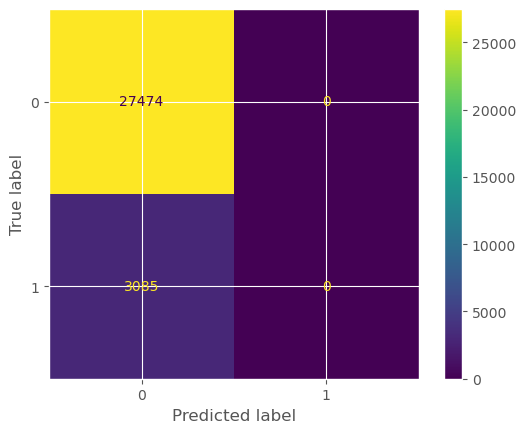

In [721]:
# plot confusion matrix
plot_confusion_matrix(lr_imb_model,X_test,y_test)

#### Note: Logistic model has yielded an accuracy score of 90% , which means that the model would make wrong predictions and would be more inclined to the frequently occurring classes which is associated with imbalanced class weights.

In [722]:
## Adding a hyperparameter class_weight to analyze the f1-score and precision
lr_bal=LogisticRegression(random_state=42,class_weight='balanced')
lr_bal_model=lr_bal.fit(X_train,y_train)
y_pred_bal=lr_bal_model.predict(X_test)
print('Classification report for balanced classes \n',classification_report(y_test,y_pred_bal))

Classification report for balanced classes 
               precision    recall  f1-score   support

           0       0.93      0.52      0.67     27474
           1       0.13      0.66      0.22      3085

    accuracy                           0.53     30559
   macro avg       0.53      0.59      0.45     30559
weighted avg       0.85      0.53      0.62     30559



/Users/vasanthchetan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


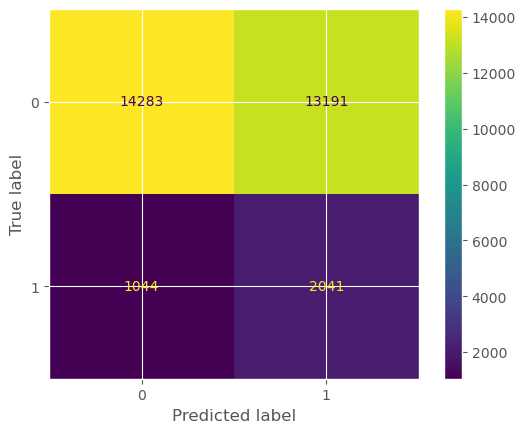

In [723]:
## Plot the confusion matrix
plot_confusion_matrix(lr_bal_model,X_test,y_test)

In [724]:
## Logistic regression with hyperparameter tuning to balance the output variable
lr_bal2=LogisticRegression(random_state=42,class_weight={0: 0.32,1: 0.68})
start = time.time()
lr_bal2.fit(X_train,y_train)
stop = time.time()
lr_bal2_train_time = round(stop - start,4)
print(f"Training time: {round(stop - start,4)}s")

y_pred_bal2=lr_bal2.predict(X_test)
print(classification_report(y_test,y_pred_bal2))

Training time: 0.1275s
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     27474
           1       0.27      0.01      0.03      3085

    accuracy                           0.90     30559
   macro avg       0.58      0.50      0.49     30559
weighted avg       0.84      0.90      0.85     30559



/Users/vasanthchetan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


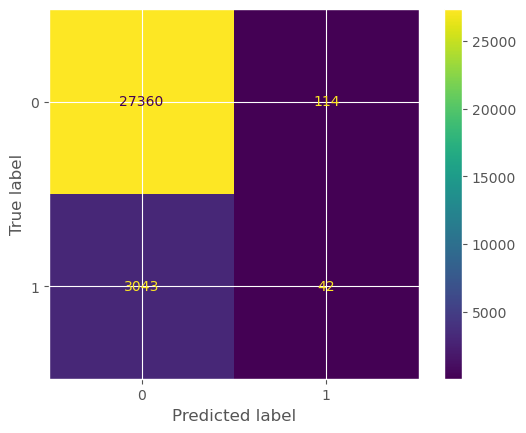

In [725]:
## Plot the confusion matrix. Notice that the f1-score has improved.
plot_confusion_matrix(lr_bal2,X_test,y_test)

In [617]:
## compute the accuracy score for the optimized logistic regression
logreg2_train_accuracy = lr_bal2.score(X_train, y_train)

## Test data model prediction accuracy
print(logreg2_train_accuracy)

logreg2_test_accuracy = lr_bal2.score(X_test, y_test)

## Test data model prediction accuracy
print(logreg2_test_accuracy)

0.8939651786883099
0.8950227428908014


In [726]:
new_r = {"Model": "Logistic Regression - Optimized", 
         "Train Time": lr_bal2_train_time, 
         "Train Accuracy":logreg2_train_accuracy,
         "Test Accuracy":logreg2_test_accuracy}
df_results.loc[len(df_results)] = new_r

In [727]:
df_results

,Model,Train Time,Train Accuracy,Test Accuracy
0,Baseline - RandomForest Classifier,1.0999,0.852468,0.774273
1,Logistic Regression,0.0311,0.897107,0.898753
2,Decision Tree Classifier,0.0334,0.940568,0.851566
3,KNeighbors Classifier,0.0068,0.899201,0.888118
4,Support Vector Classifier,0.8681,0.896976,0.899048
5,Logistic Regression - Optimized,0.1275,0.893965,0.895023


### Tune DecisionTreeClassifier hyperparameter - max_depth to avoid overfitting the train data 

In [728]:
for max_d in range(1,21):
    model = DecisionTreeClassifier(max_depth=max_d, random_state=42)
    model.fit(X_train,y_train)
    print('The Training Accuracy for max_depth {} is:'.format(max_d), model.score(X_train,y_train))
    print('The Validation Accuracy for max_depth {} is:'.format(max_d), model.score(X_test,y_test))
    print('')

The Training Accuracy for max_depth 1 is: 0.8969760439848148
The Validation Accuracy for max_depth 1 is: 0.899047743708891

The Training Accuracy for max_depth 2 is: 0.8969760439848148
The Validation Accuracy for max_depth 2 is: 0.899047743708891

The Training Accuracy for max_depth 3 is: 0.8971069511716193
The Validation Accuracy for max_depth 3 is: 0.8984587191989266

The Training Accuracy for max_depth 4 is: 0.8977614871056421
The Validation Accuracy for max_depth 4 is: 0.8986550607022481

The Training Accuracy for max_depth 5 is: 0.8984160230396648
The Validation Accuracy for max_depth 5 is: 0.8981969305278314

The Training Accuracy for max_depth 6 is: 0.8993323733472968
The Validation Accuracy for max_depth 6 is: 0.8959390032396348

The Training Accuracy for max_depth 7 is: 0.9007723524021469
The Validation Accuracy for max_depth 7 is: 0.8961680683268431

The Training Accuracy for max_depth 8 is: 0.902212331456997
The Validation Accuracy for max_depth 8 is: 0.894106482541968

The 

In [729]:
#Create Decision Tree classifer object with MAX depth = 7
dt_clf = DecisionTreeClassifier(max_depth=7)  # default parameters

# Train data fit start time
start = time.time()

## fit the decisiontreeClassifier with train data
dt_clf = dt_clf.fit(X_train,y_train)

# Train data fit end time
stop = time.time()

dt_train_time = round(stop - start,4)
print(f"Training time: {round(stop - start,4)}s")

Training time: 0.0105s


In [730]:
# DecisionTreeClassifier model accuracy when using train data
dt_train_accuracy = metrics.accuracy_score(y_train, dt_clf.predict(X_train))
print('DecisionTreeClassifier  model accuracy using train data:\n',dt_train_accuracy)
print("\n")

# DecisionTreeClassifier model accuracy when using test data
dt_test_accuracy = metrics.accuracy_score(y_test, dt_clf.predict(X_test))
print('DecisionTreeClassifier  model accuracy using test data:\n',dt_test_accuracy)

DecisionTreeClassifier  model accuracy using train data:
 0.9007723524021469


DecisionTreeClassifier  model accuracy using test data:
 0.8961353447429562


In [731]:
## save the decisiontreeClassifier model findings
new_r = {"Model": "Decision Tree Classifier - Optimizied", 
         "Train Time": dt_train_time, 
         "Train Accuracy":dt_train_accuracy,
         "Test Accuracy":dt_test_accuracy}
df_results.loc[len(df_results)] = new_r

In [732]:
df_results

,Model,Train Time,Train Accuracy,Test Accuracy
0,Baseline - RandomForest Classifier,1.0999,0.852468,0.774273
1,Logistic Regression,0.0311,0.897107,0.898753
2,Decision Tree Classifier,0.0334,0.940568,0.851566
3,KNeighbors Classifier,0.0068,0.899201,0.888118
4,Support Vector Classifier,0.8681,0.896976,0.899048
5,Logistic Regression - Optimized,0.1275,0.893965,0.895023
6,Decision Tree Classifier - Optimizied,0.0105,0.900772,0.896135


### KNN with hyperparameter tuning

In [733]:
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [734]:
## Grid seach for tuned parameters
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

In [735]:
# fit the GS model on train data
g_res = gs.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/Users/vasanthchetan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/vasanthchetan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None 

/Users/vasanthchetan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/vasanthchetan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None 

/Users/vasanthchetan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/vasanthchetan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None 

/Users/vasanthchetan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/vasanthchetan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None 

In [744]:
# find the best score
g_res.best_score_

0.897106844838893

In [745]:
# Get hyperparameters with the best score
g_res.best_params_

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}

In [746]:
## Create KNN model with hyperparamters from best score
knn2 = KNeighborsClassifier(n_neighbors = 15, weights = 'uniform',algorithm = 'brute',metric = 'manhattan')
start = time.time()
knn2.fit(X_train, y_train)
stop = time.time()
knn2_train_time = round(stop - start,4)

In [747]:
# Calculate the accuracy of the KNN model using hyperparamters 
knn2_train_accuracy = metrics.accuracy_score(y_train, knn2.predict(X_train))
print("Training Accuracy:",knn2_train_accuracy) 
knn2_test_accuracy = metrics.accuracy_score(y_test, knn2.predict(X_test))
# Calculate the accuracy of the model 
print("Test Accuracy:",knn2_test_accuracy) 

Training Accuracy: 0.8972378583584238
Test Accuracy: 0.898687784286135


In [748]:
## save the findings
new_r = {"Model": "KNNeighbors Classifier - Optimizied", 
         "Train Time": knn2_train_time, 
         "Train Accuracy":knn2_train_accuracy,
         "Test Accuracy":knn2_test_accuracy}
df_results.loc[len(df_results)] = new_r

In [741]:
df_results

,Model,Train Time,Train Accuracy,Test Accuracy
0,Baseline - RandomForest Classifier,1.0999,0.852468,0.774273
1,Logistic Regression,0.0311,0.897107,0.898753
2,Decision Tree Classifier,0.0334,0.940568,0.851566
3,KNeighbors Classifier,0.0068,0.899201,0.888118
4,Support Vector Classifier,0.8681,0.896976,0.899048
5,Logistic Regression - Optimized,0.1275,0.893965,0.895023
6,Decision Tree Classifier - Optimizied,0.0105,0.900772,0.896135
7,KNeighbors Classifier - Optimizied,0.0070,0.897238,0.898688


# SVM with hyperparameter tuning

In [742]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.897 total time=   2.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.897 total time=   2.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.897 total time=   2.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.897 total time=   2.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.897 total time=   2.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.897 total time=   1.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.897 total time=   1.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.897 total time=   1.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.897 total time=   1.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.897 total time=   1.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.897 total time=   0.8s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.874 total time=   2.4s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.878 total time=   2.4s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.883 total time=   2.5s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.883 total time=   2.5s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.843 total time=  11.7s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.843 total time=  16.9s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.842 total time=  14.6s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.849 total time=  10.6s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.845 total time=  14.6s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.895 total time=  42.4s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.899 total time=  49.9s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.895 total time=  43.9s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [749]:
# print best parameter
print(grid.best_params_) 
  
# print the best estimator
print(grid.best_estimator_) 

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=0.1, gamma=1)


In [750]:
#Create a svc Classifier with best parameters
svc_clf = SVC(C=1000, gamma=0.001) # default parameters, rbf Kernel

#Train the model using the training sets
start = time.time()
svc_clf.fit(X_train, y_train)
stop = time.time()
svc_clf_train_time = round(stop - start,4)
print(f"Training time: {round(stop - start,4)}s")

Training time: 28.0895s


In [751]:
# SVM Model Accuracy
svc_clf_train_accuracy = metrics.accuracy_score(y_train, svc_clf.predict(X_train))
print('SVM model accuracy using train data:\n',svc_clf_train_accuracy)
print("\n")
svc_clf_test_accuracy = metrics.accuracy_score(y_test, svc_clf.predict(X_test))
print('SVM model accuracy using test data:\n',svc_clf_test_accuracy)

SVM model accuracy using train data:
 0.8971069511716193


SVM model accuracy using test data:
 0.8986550607022481


In [752]:
new_r = {"Model": "Support Vector Classifier - Optimized", 
         "Train Time": svc_clf_train_time, 
         "Train Accuracy":svc_clf_train_accuracy,
         "Test Accuracy":svc_clf_test_accuracy}
df_results.loc[len(df_results)] = new_r

In [753]:
df_results

,Model,Train Time,Train Accuracy,Test Accuracy
0,Baseline - RandomForest Classifier,1.0999,0.852468,0.774273
1,Logistic Regression,0.0311,0.897107,0.898753
2,Decision Tree Classifier,0.0334,0.940568,0.851566
3,KNeighbors Classifier,0.0068,0.899201,0.888118
4,Support Vector Classifier,0.8681,0.896976,0.899048
5,Logistic Regression - Optimized,0.1275,0.893965,0.895023
6,Decision Tree Classifier - Optimizied,0.0105,0.900772,0.896135
7,KNeighbors Classifier - Optimizied,0.0070,0.897238,0.898688
8,KNNeighbors Classifier - Optimizied,0.0076,0.897238,0.898688
9,Support Vector Classifier - Optimized,28.0895,0.897107,0.898655


### Conclusion

#### DecisionTree classifier or KNearestNeighbor classifier is the best model to target customers. SVM took a long time to train and might be not be suitable for dataset with large samples. Logistic regression classifier accuracy could not be improved after tuning. DecisionTree and KNearestNeighbor classifier with tuned hyperparameters are the best performing classifier and does not overfit on the training data. This model can be deployed to production for sales,customer service team to access quickly and provide necessary marketing data for customers to decide on opening an deposit account.